### Time Series Analysis on Air Passengers data

### Table of contents:
- <a href='#1'>1.Importing data</a><br/>        
- <a href='#2'>2.Plotting the data</a>
- <a href='#3'>3.Check Stationarity</a>
- <a href='#4'>4.Log Transformation</a>
- <a href='#5'>5.Simple moving average</a>
- <a href='#5.1'>6. Exponentially weighted moving average </a>
- <a href='#6'>7.Eliminating Trend and Seasonality</a>
- <a href='#7'>8.ACF and PACF plots</a>
- <a href='#8'>9.Algorithm Selection</a>

### <a id='1'> 1. Importing the data </a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 


In [0]:
df =  pd.read_csv("AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'])

In [0]:
# Loading the dataset
air_passengers = pd.read_csv("AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'])

In [0]:
air_passengers.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


Top 5 rows of data

In [0]:
air_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month         144 non-null datetime64[ns]
Passengers    144 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


**Observations:**  Notice the dtype=’datetime[ns]’ which confirms that it is a datetime object. <br>
No of rows: 144<br/>
No.of columns: 2<br/>

In [0]:
air_passengers.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


**Missing values if any**

In [0]:
air_passengers.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [0]:
ts = air_passengers.set_index('Month', drop=True)

In [0]:
ts.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**Note:** Now we can see that the data has **month** object as index and **Passengers** as column. 

### <a id='2'>**2. Simply plot the data and analyze visually** </a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


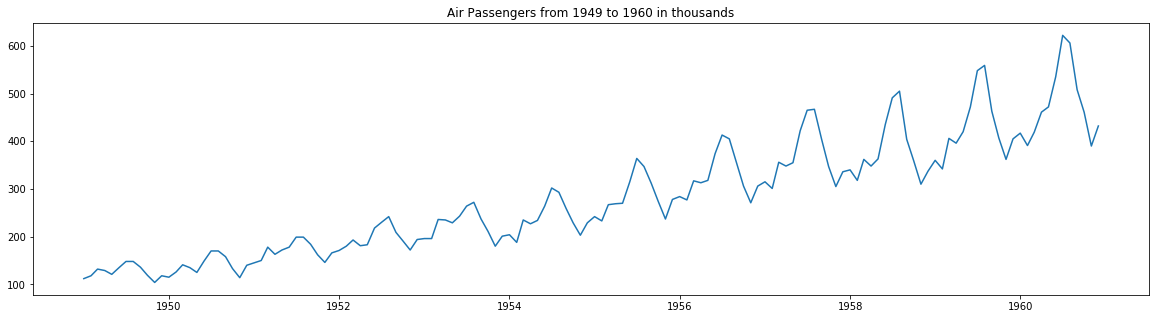

In [0]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
plt.plot(ts)
plt.title('Air Passengers from 1949 to 1960 in thousands')
pyplot.show();

**Observations:**<br/>
From the above plot, it is clear that there is an increasing trend as more and more people are taking flights.

### Stationary

*A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.*<br/>


**But why is it important?** <br/>
Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

*There are three basic criterion for a series to be classified as stationary series :* 

1. Constant mean
2. Constant variance
3. an autocovariance that does not depend on time.

**Why do I care about ‘stationarity’ of a time series?**<br/>
The reason is that until unless your time series is stationary, you cannot build a time series model. In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try models to predict this time series. 

### <a id='3'> **3. Check Stationarity of time series** </a>

Stationary testing and converting a series into a stationary series are the most critical processes in a time series modelling.

**Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. 

1. *Null hypothesis is that the TS is non-stationary.* <br/>
2. *The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.* <br/>
3. *If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.*

**Note:** I have defined a function to use rolling statistics plots along with Dickey-Fuller test results to check stationarity.

In [0]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [0]:
def test_stationarity(timeseries):
    print("Results of Dickey-Fuller Test:")
    result = adfuller(timeseries,autolag='AIC')
    labels=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+ " : "+str(value))

    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary")


In [0]:
test_stationarity(ts['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic : 0.815368879206047
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
Fail to reject the null hypothesis. Data is non-stationary


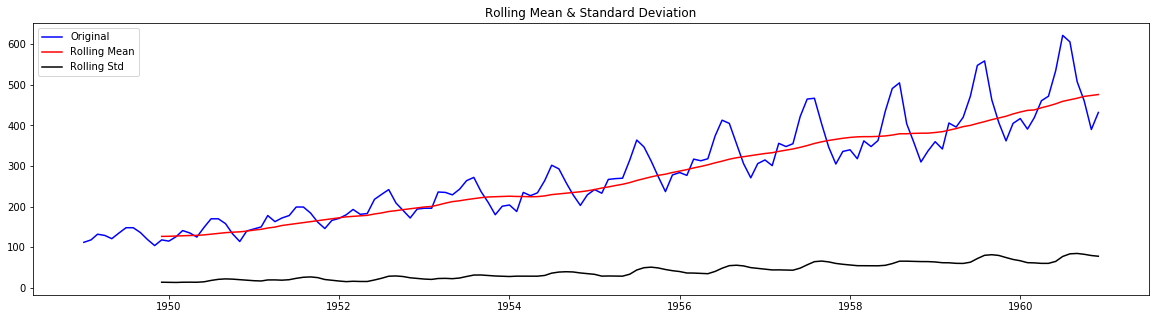

<Figure size 1440x360 with 0 Axes>

In [0]:
#Determing rolling statistics
rolmean = ts['Passengers'].rolling(12).mean()
rolstd = ts['Passengers'].rolling(12).std()

#Plot rolling statistics:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
orig = plt.plot(ts['Passengers'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.figure(figsize=(20,5))
pyplot.show(block=False)

**Observations:**<br/>
Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is more than the critical values. p-value also greater than threshold(0.05). Accept null hypothesis.

### <a id='3'> **How to make a Time Series Stationary?** </a>

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationarity of a TS:
1. **Trend** – varying mean over time. 
2. **Seasonality** – variations at specific time-frames.

*The main principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series.* 

**One of the first ways to reduce trend can be transformation**. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.

### <a id='4'> 4. Log transformation </a>

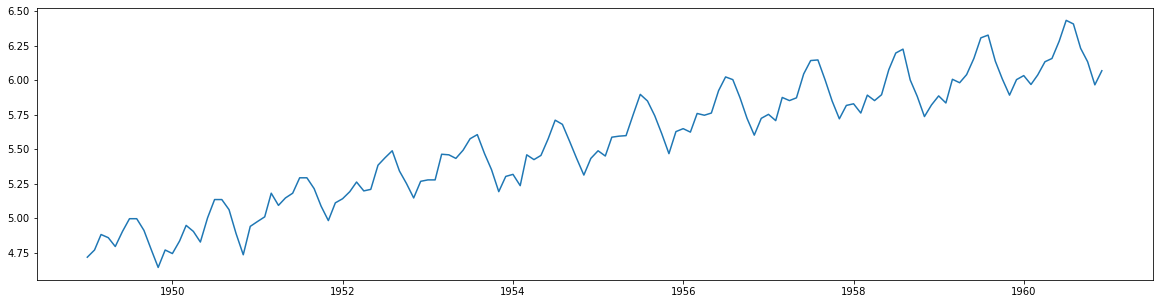

In [0]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
ts_log = np.log(ts)
plt.plot(ts_log)
pyplot.show()

**Note:** It is not easy to see a trend in the data, in presence of noise. So we can use smoothing techniques(taking rolling averages) to estimate or model this trend and then remove it from the series.

*Smoothing refers to taking rolling estimates, i.e. considering the past few instances.*
1. Simple Moving average
2. Weighted Moving average
3. Exponential smoothing

### <a id='5'> 5. Simple Moving Average </a><br/>

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

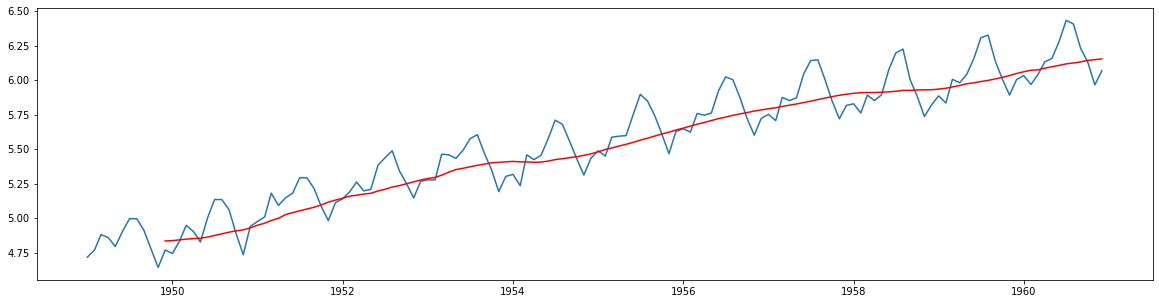

In [0]:
plt.figure(figsize=(20,5))
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
pyplot.show()

In [0]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12) #Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff.Passengers)

Results of Dickey-Fuller Test:
Test Statistic : -3.162907991300857
p-value : 0.022234630001243903
#Lags Used : 13
Number of Observations Used : 119
Reject the null hypothesis. Data is stationary


**Observations:** Reject Null Hypothesis.. Time Series is stationary.

However, a drawback in this particular approach is that the *time-period has to be strictly defined*. In this case we can take yearly averages but in *complex situations like forecasting a stock price, its difficult to come up with a number*. So we take a **‘weighted moving average’ where more recent values are given a higher weight.** There can be many technique for assigning weights. **A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.** Find details here. This can be implemented in Pandas as:

### <a id='5.1'> 6. Exponentially weighted moving average </a><br/>
Weights are assigned to all the previous values with a decay factor.

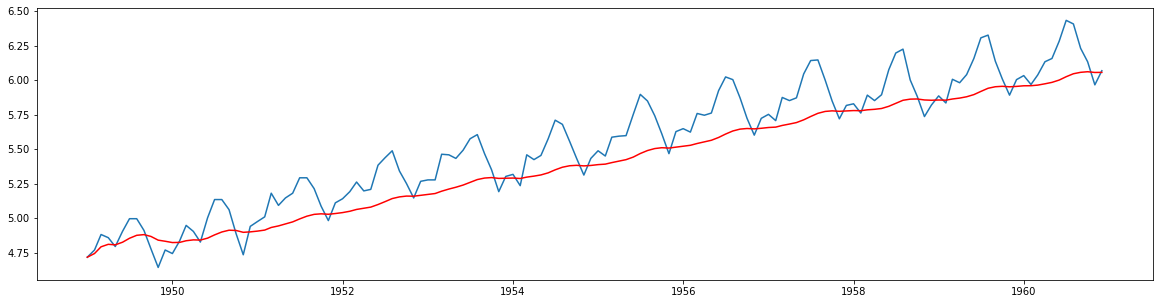

In [0]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))

expwighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
pyplot.show()

**Note:** the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay . Lets remove this from series and check stationarity:

In [0]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff.Passengers)

Results of Dickey-Fuller Test:
Test Statistic : -3.6012624201616723
p-value : 0.005736938801511978
#Lags Used : 13
Number of Observations Used : 130
Reject the null hypothesis. Data is stationary


**Observations:**<br/>
This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the critical value, p-value is less than 0.05,  reject null hypothesis. TS is stationary now.

### <a id='6'> 7. Eliminating Trend and Seasonality </a>

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.<br/> 
Lets discuss aonther way of removing trend and seasonality:<br/>
*1. Differencing* – taking the differece with a particular time lag<br/>
*2. Decomposition* - modeling both trend and seasonality and removing them from the model.<br/>

**Differencing**

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

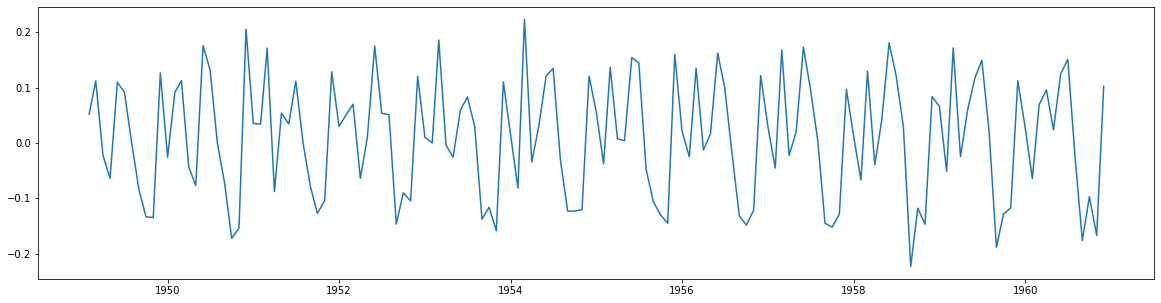

In [0]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

This appears to have reduced trend considerably. Lets verify using our plots:

In [0]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.Passengers)

Results of Dickey-Fuller Test:
Test Statistic : -2.7171305983881284
p-value : 0.0711205481508595
#Lags Used : 14
Number of Observations Used : 128
Fail to reject the null hypothesis. Data is non-stationary


**Observations:** We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. 

**Decomposition**

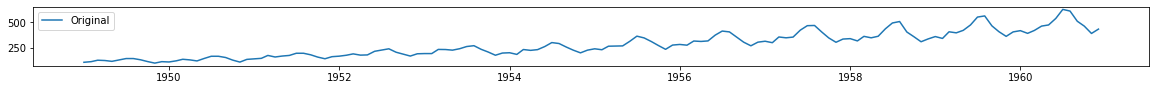

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,5))
decomposition = seasonal_decompose(ts_log, model = 'additive', freq = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
pyplot.show()

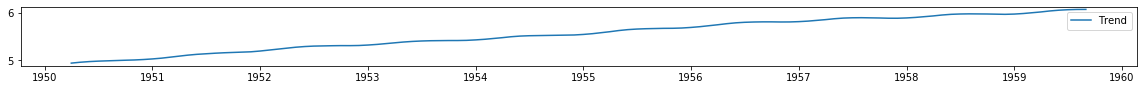

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
pyplot.show()

**Observations:** if you see the above graph, there is a upwards trend.

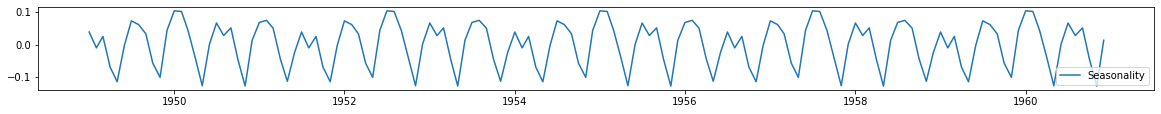

In [0]:
plt.figure(figsize=(20,7))
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
pyplot.show()

**Observations:** There is seasonality

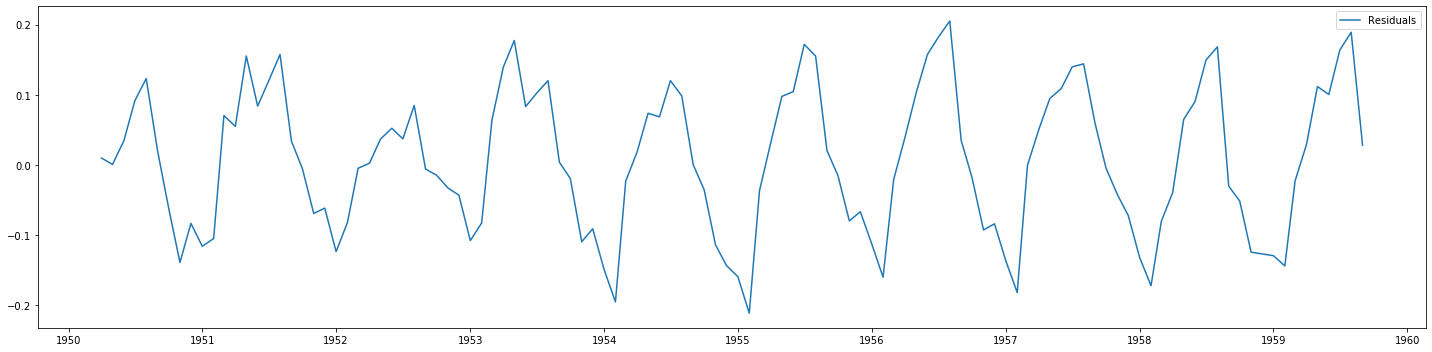

In [0]:
plt.figure(figsize=(20,5))
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
pyplot.show()

**Lets remove trend from the data**

In [0]:
ts_log_decompose = ts_log - trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.Passengers)

Results of Dickey-Fuller Test:
Test Statistic : -3.2111119685829697
p-value : 0.019350417744556522
#Lags Used : 13
Number of Observations Used : 100
Reject the null hypothesis. Data is stationary


**Observations**<br/>
The Dickey-Fuller test statistic is very significantly lower than the 5% critical value. Also p-value is less than threshold(0.05). Reject null hypothesis and proves that TS is stationary.

**Now the time series is stationary and there is no trend or seasonality. Lets decompose this series again and visualize the same**

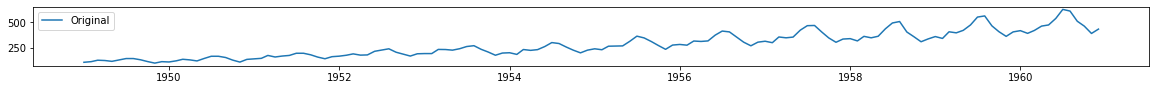

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,5))
decomposition1 = seasonal_decompose(ts_log_decompose, model = 'additive', freq = 30)

trend1 = decomposition1.trend
seasonal1 = decomposition1.seasonal
residual1 = decomposition1.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
pyplot.show()

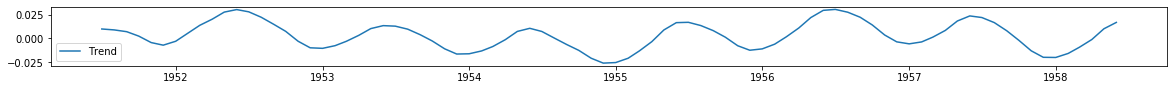

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(412)
plt.plot(trend1, label='Trend')
plt.legend(loc='best')
pyplot.show()

**Note: If you notice clearly, there is no trend in this timeseries as we have already removed it**

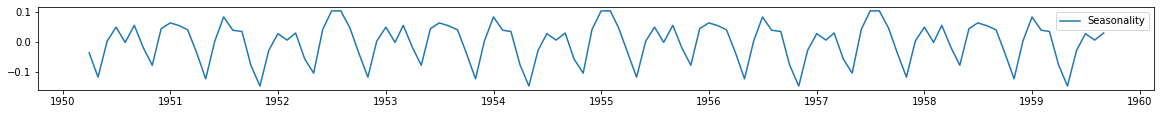

In [0]:
plt.figure(figsize=(20,7))
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality')
plt.legend(loc='best')
pyplot.show()

**Forecasting Time Series**

**ARIMA**

ARIMA stands for **Auto-Regressive Integrated Moving Averages**. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters **(p,d,q) of the ARIMA model**:

**Number of AR (Auto-Regressive) terms (p):** AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).<br/>

**Number of MA (Moving Average) terms (q):** MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.<br/>

**Number of Differences (d):** These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.<br/>

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

### <a id='7'> 8. ACF and PACF plots </a>

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


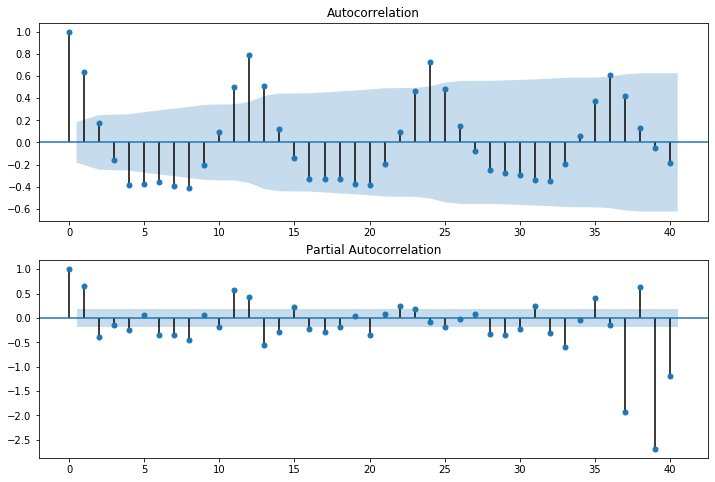

In [0]:
import statsmodels.api as sm

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_decompose.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_decompose, lags=40, ax=ax2)
plt.show()

**Observations:**<br/>
In the above two plots, the blue shaded area on the either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values.<br/>
p – The lag value where the PACF chart crosses the upper confidence interval. If you notice closely, in this case p=1.<br/>
q – The lag value crosses the confidence interval. q=2.<br/>

### <a id='8'> 9. Algorithm Selection </a>

### Auto ARIMA

We will use auto-arima which will automatically pick the best hyperparamaters for time series modelling.

In [0]:
from pmdarima import auto_arima

In [0]:
ts.shape

(144, 1)

In [0]:
#divide into train and validation set
train = ts[:int(0.7*(len(ts)))]
test = ts[int(0.7*(len(ts))):]
print(train.shape)
print(test.shape)

(100, 1)
(44, 1)


In [0]:
#training model
model = auto_arima(train, trace=True,start_p=1, start_q=1, start_P=0, start_Q=0,
                  max_p=8, max_q=8, max_P=8, max_Q=8, seasonal=True,m=12,
                  stepwise=False, suppress_warnings=True, D=1, max_D=8,
                  error_action='ignore',approximation = False)
#fitting model
model.fit(train)

Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=652.680, BIC=657.612, Time=0.022 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=649.037, BIC=656.435, Time=0.166 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=650.859, BIC=660.722, Time=0.506 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 3, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 4, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 5, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=649.280, BIC=656.678, Time=0.194 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=650.955, BIC=660.819, Time=0.305 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=648.716, BIC=661.045, Time=2.597 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 3, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 4, 12) (constant=True); AIC=nan, BIC=nan, 

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

Best model has an order of (1,1,1) and seasonal_order of (1,1,2,12)

In [0]:
prediction = pd.DataFrame(model.predict(n_periods=44), index=test.index)
prediction.columns = ['Predicted Passengers']

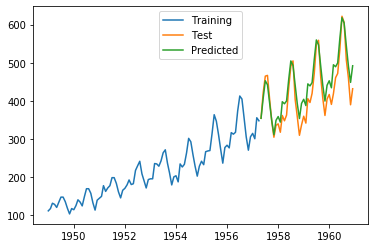

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
plt.plot(train,label='Training')
plt.plot(test,label='Test')
plt.plot(prediction,label='Predicted')
plt.legend(loc='upper center')